# Risk Parity vs Equal Weight Portfolio Backtest (2007–2026)

## Objective
This project compares different portfolio allocation strategies:
- Equal Weight Portfolio
- Risk Parity Portfolio
- Risk Parity with Transaction Costs
- Risk Parity Leveraged Portfolio
- Risk Parity Leveraged with Transaction Costs

The strategies are evaluated using performance metrics such as CAGR, volatility, Sharpe ratio, drawdowns, rolling returns, and turnover.


## Imports

In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

## Download Prices

In [519]:
tickers = ["SPY", "EFA", "IEF", "TLT", "GLD", "DBC", "VNQ", "BIL"]
start_date = "2004-01-01"
end_date = "2026-02-05"

raw = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

if "Adj Close" in raw.columns.get_level_values(0):
    prices = raw["Adj Close"]
else:
    prices = raw["Close"]

prices = prices.dropna()

print(prices.head())
print(prices.shape)

[*********************100%***********************]  8 of 8 completed

Ticker            BIL        DBC        EFA        GLD        IEF         SPY  \
Date                                                                            
2007-05-30  71.608437  20.532070  45.780907  64.720001  51.358654  108.337288   
2007-05-31  71.608437  20.718870  46.008015  65.540001  51.339813  108.224304   
2007-06-01  71.624016  20.873184  46.308937  66.440002  51.118610  108.760765   
2007-06-04  71.639709  21.059986  46.433842  66.540001  51.200542  108.774849   
2007-06-05  71.639709  20.978769  46.195396  66.370003  51.036694  108.344322   

Ticker            TLT        VNQ  
Date                              
2007-05-30  48.676060  36.153183  
2007-05-31  48.586033  36.007248  
2007-06-01  48.330833  36.057415  
2007-06-04  48.551044  36.203365  
2007-06-05  48.246124  35.628696  
(4702, 8)


## Compute Returns

In [521]:
returns = prices.pct_change().dropna()

print(returns.head())
print(returns.shape)

Ticker           BIL       DBC       EFA       GLD       IEF       SPY  \
Date                                                                     
2007-05-31  0.000000  0.009098  0.004961  0.012670 -0.000367 -0.001043   
2007-06-01  0.000218  0.007448  0.006541  0.013732 -0.004309  0.004957   
2007-06-04  0.000219  0.008949  0.002697  0.001505  0.001603  0.000129   
2007-06-05  0.000000 -0.003856 -0.005135 -0.002555 -0.003200 -0.003958   
2007-06-06  0.000436 -0.000387 -0.014381  0.000603  0.000495 -0.010750   

Ticker           TLT       VNQ  
Date                            
2007-05-31 -0.001850 -0.004037  
2007-06-01 -0.005253  0.001393  
2007-06-04  0.004556  0.004048  
2007-06-05 -0.006280 -0.015873  
2007-06-06 -0.000468 -0.006785  
(4701, 8)


## Equal Weight Backtest

In [525]:
n_assets = returns.shape[1]
equal_weights = np.ones(n_assets) / n_assets

equal_portfolio_returns = returns.dot(equal_weights)

equal_equity_curve = (1 + equal_portfolio_returns).cumprod()

print(equal_equity_curve.tail())

Date
2026-01-29    3.119512
2026-01-30    3.059282
2026-02-02    3.028697
2026-02-03    3.059999
2026-02-04    3.064292
dtype: float64


## Risk Parity Optimize

In [529]:
from scipy.optimize import minimize

def risk_parity_weights(cov_matrix):

    n = cov_matrix.shape[0]

    def portfolio_vol(w):
        return np.sqrt(w.T @ cov_matrix @ w)

    def risk_contribution(w):
        port_vol = portfolio_vol(w)
        mrc = cov_matrix @ w
        rc = (w * mrc) / port_vol
        return rc

    def objective(w):
        rc = risk_contribution(w)
        target_rc = np.ones(n) * (rc.sum() / n)
        return np.sum((rc - target_rc) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    bounds = tuple((0.01, 0.50) for _ in range(n))

    # IMPORTANT: random initial guess instead of equal
    w0 = np.random.random(n)
    w0 = w0 / w0.sum()

    result = minimize(objective, w0, method="SLSQP",
                      bounds=bounds, constraints=constraints)

    if not result.success:
        print("Optimization failed:", result.message)
        return np.ones(n) / n

    return result.x

In [531]:
test_cov = returns.tail(252).cov().values
test_weights = risk_parity_weights(test_cov)

print(pd.Series(test_weights, index=returns.columns))
print("Sum:", test_weights.sum())

Ticker
BIL    0.067272
DBC    0.194259
EFA    0.010000
GLD    0.099514
IEF    0.125703
SPY    0.044960
TLT    0.182544
VNQ    0.275748
dtype: float64
Sum: 1.0


## Risk Parity Backtest

In [535]:
def backtest_risk_parity(returns, lookback_days=252, rebalance_freq="ME"):

    tickers = returns.columns
    rebalance_dates = returns.resample("ME").last().index

    weights_list = []
    weight_dates = []

    for date in rebalance_dates:

        if date not in returns.index:
            date = returns.index[returns.index.get_indexer([date], method="nearest")[0]]

        end_loc = returns.index.get_loc(date)

        if end_loc < lookback_days:
            continue

        window = returns.iloc[end_loc - lookback_days:end_loc]
        cov_matrix = window.cov().values

        w = risk_parity_weights(cov_matrix)

        weights_list.append(w)
        weight_dates.append(date)

    rp_rebalance_weights = pd.DataFrame(weights_list, index=weight_dates, columns=tickers)

    # forward fill weights daily
    rp_daily_weights = rp_rebalance_weights.reindex(returns.index).ffill().dropna()

    # portfolio returns (use yesterday's weights)
    rp_daily_returns = (rp_daily_weights.shift(1) * returns.loc[rp_daily_weights.index]).sum(axis=1)

    rp_equity = (1 + rp_daily_returns).cumprod()

    return rp_equity, rp_rebalance_weights, rp_daily_weights, rp_daily_returns

In [537]:
rp_equity, rp_rebalance_weights, rp_daily_weights, rp_daily_returns = backtest_risk_parity(returns)

print(rp_rebalance_weights.head())
print(rp_rebalance_weights.tail())

Ticker           BIL       DBC       EFA       GLD       IEF       SPY  \
2008-05-30  0.151943  0.061954  0.078638  0.287811  0.173726  0.062631   
2008-06-30  0.065086  0.134159  0.023551  0.077308  0.163679  0.167502   
2008-07-31  0.046316  0.245969  0.039722  0.171753  0.071572  0.177826   
2008-09-02  0.034240  0.056824  0.023593  0.186910  0.102617  0.182949   
2008-09-30  0.091412  0.139129  0.099785  0.186749  0.166290  0.071146   

Ticker           TLT       VNQ  
2008-05-30  0.164443  0.018853  
2008-06-30  0.204789  0.163925  
2008-07-31  0.131191  0.115652  
2008-09-02  0.195970  0.216897  
2008-09-30  0.083477  0.162012  
Ticker           BIL       DBC       EFA       GLD       IEF       SPY  \
2025-10-31  0.278802  0.040039  0.076780  0.010000  0.174893  0.120739   
2025-12-01  0.147626  0.151103  0.143210  0.160308  0.161666  0.080733   
2025-12-31  0.067818  0.036667  0.221832  0.010000  0.100044  0.232281   
2026-01-30  0.140874  0.087886  0.158321  0.010000  0.165171 

## Transaction Costs Model

In [539]:
transaction_cost_rate = 0.001   # 10 bps per $ traded (0.10%)

# turnover = sum(|w_t - w_(t-1)|)
turnover = rp_daily_weights.diff().abs().sum(axis=1)

# cost applies ONLY on rebalance days (when turnover > 0)
trading_cost = turnover * transaction_cost_rate

# apply cost to daily returns
rp_returns_after_cost = rp_daily_returns - trading_cost

# equity curve after cost
rp_equity_after_cost = (1 + rp_returns_after_cost).cumprod()

print("===== TRANSACTION COSTS APPLIED =====")
print("Average daily turnover:", turnover.mean())
print("Average daily cost:", trading_cost.mean())


===== TRANSACTION COSTS APPLIED =====
Average daily turnover: 0.03124500353506777
Average daily cost: 3.124500353506777e-05


## Leveraged RP model

In [545]:
target_vol = 0.12   # target annual volatility (12%)
lookback_vol = 63   # 3 months rolling vol

rolling_vol = rp_daily_returns.rolling(lookback_vol).std() * np.sqrt(252)

leverage = target_vol / rolling_vol
leverage = leverage.clip(0, 2.0)   # max leverage cap = 2x

# Apply leverage with 1-day lag (no lookahead bias)
rp_levered_returns = rp_daily_returns * leverage.shift(1)

# Equity curve
rp_levered_equity = (1 + rp_levered_returns).cumprod()

print("===== LEVERAGE MODEL READY =====")
print(leverage.dropna().describe())

===== LEVERAGE MODEL READY =====
count    4387.000000
mean        1.516559
std         0.458361
min         0.255356
25%         1.200156
50%         1.593629
75%         2.000000
max         2.000000
dtype: float64


## Metrics Calculation

In [550]:
def performance_metrics(returns, name="Portfolio"):
    returns = returns.dropna()

    equity = (1 + returns).cumprod()

    # CAGR
    years = (returns.index[-1] - returns.index[0]).days / 365.25
    cagr = equity.iloc[-1] ** (1 / years) - 1

    # Volatility
    vol = returns.std() * np.sqrt(252)

    # Sharpe Ratio (rf=0 assumed)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))

    # Sortino Ratio
    downside = returns[returns < 0].std() * np.sqrt(252)
    sortino = (returns.mean() * 252) / downside if downside != 0 else np.nan

    # Max Drawdown
    rolling_max = equity.cummax()
    drawdown = (equity / rolling_max) - 1
    max_dd = drawdown.min()

    # Calmar Ratio
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

    return {
        "Portfolio": name,
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Max Drawdown": max_dd,
        "Calmar": calmar
    }

## Equal Weights Returns (Benchmark)

In [553]:
equal_weights = np.ones(len(returns.columns)) / len(returns.columns)

equal_returns = (returns * equal_weights).sum(axis=1)
equal_equity = (1 + equal_returns).cumprod()

print("Equal weight benchmark created.")
print(equal_equity.tail())

Equal weight benchmark created.
Date
2026-01-29    3.119512
2026-01-30    3.059282
2026-02-02    3.028697
2026-02-03    3.059999
2026-02-04    3.064292
dtype: float64


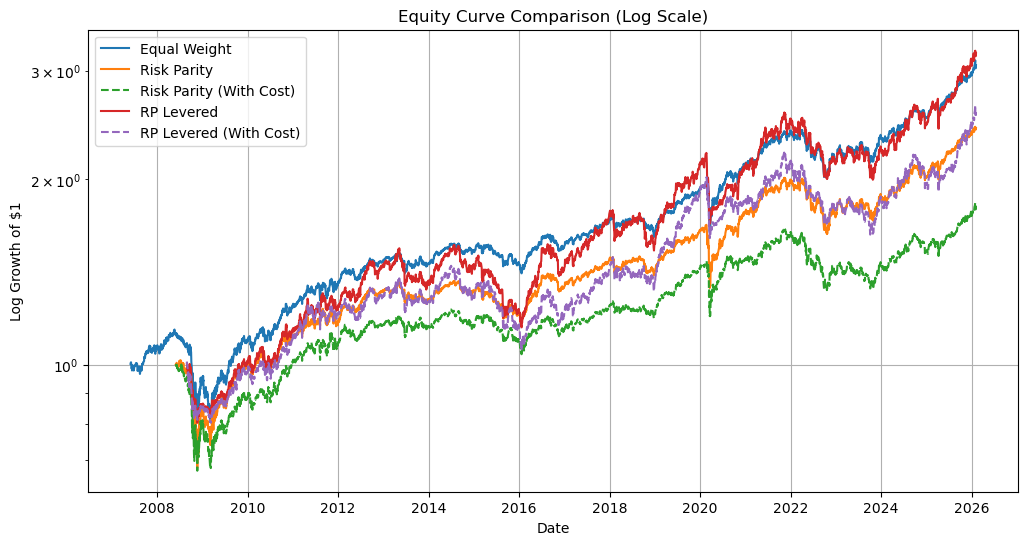

In [600]:
import os

os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(12,6))
plt.plot(equal_equity, label="Equal Weight")
plt.plot(rp_equity, label="Risk Parity")
plt.plot(rp_curve_after_cost, label="Risk Parity (With Cost)", linestyle="--")
plt.plot(rp_levered_equity, label="RP Levered")
plt.plot(rp_levered_equity_after_cost, label="RP Levered (With Cost)", linestyle="--")

plt.yscale("log")
plt.title("Equity Curve Comparison (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Log Growth of $1")
plt.grid(True)
plt.legend()

plt.savefig("outputs/equity_curve_logscale.png", dpi=300, bbox_inches="tight")
plt.show()

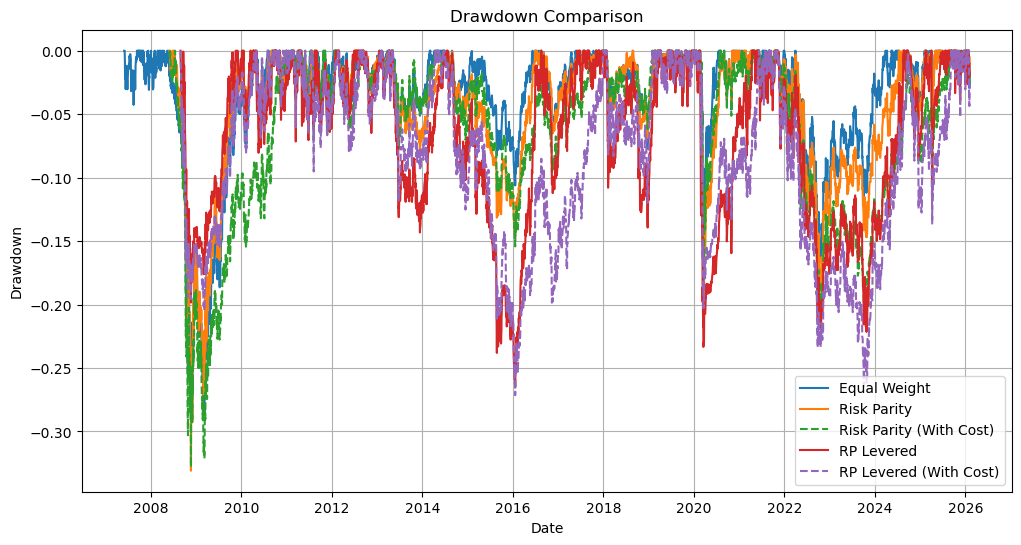

In [616]:
def drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = (equity_curve / peak) - 1
    return dd

dd_equal = drawdown(equal_equity)
dd_rp = drawdown(rp_equity)
dd_rp_cost = drawdown(rp_curve_after_cost)
dd_rp_lev = drawdown(rp_levered_equity)
dd_rp_lev_cost = drawdown(rp_levered_equity_after_cost)

plt.figure(figsize=(12,6))
plt.plot(dd_equal, label="Equal Weight")
plt.plot(dd_rp, label="Risk Parity")
plt.plot(dd_rp_cost, label="Risk Parity (With Cost)", linestyle="--")
plt.plot(dd_rp_lev, label="RP Levered")
plt.plot(dd_rp_lev_cost, label="RP Levered (With Cost)", linestyle="--")

plt.title("Drawdown Comparison")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.legend()
plt.savefig("outputs/drawdown_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


## ROLLING RETURNS (1Y, 3Y, 5Y)


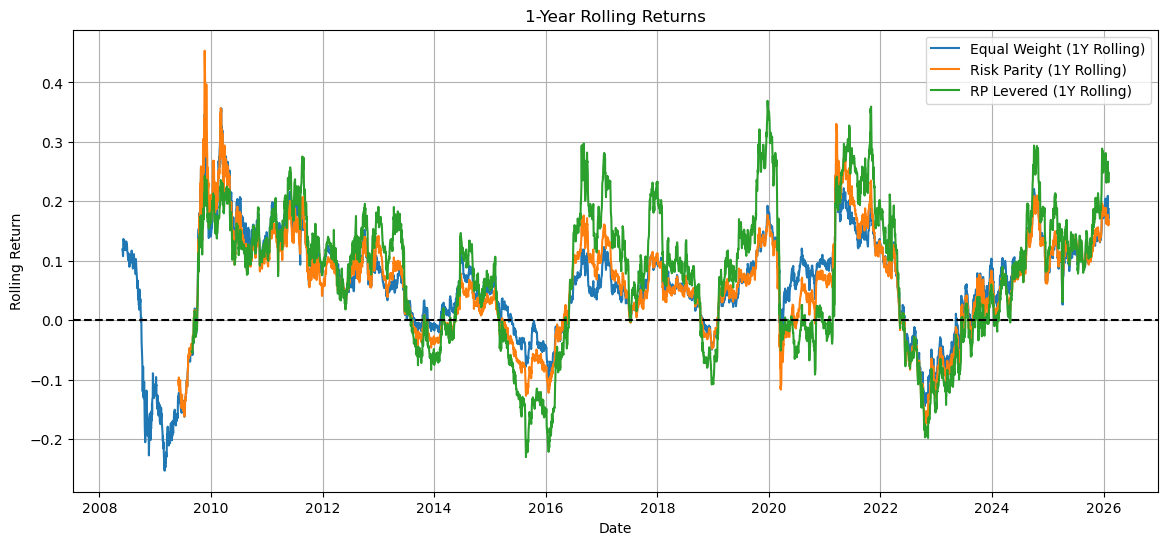

In [618]:
def rolling_return(equity_curve, window_days):
    return equity_curve.pct_change(window_days)

rolling_1y_equal = rolling_return(equal_equity, 252)
rolling_1y_rp = rolling_return(rp_equity, 252)
rolling_1y_levered = rolling_return(rp_levered_equity, 252)

plt.figure(figsize=(14,6))
plt.plot(rolling_1y_equal, label="Equal Weight (1Y Rolling)")
plt.plot(rolling_1y_rp, label="Risk Parity (1Y Rolling)")
plt.plot(rolling_1y_levered, label="RP Levered (1Y Rolling)")
plt.axhline(0, color="black", linestyle="--")
plt.title("1-Year Rolling Returns")
plt.xlabel("Date")
plt.ylabel("Rolling Return")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_returns_1y.png", dpi=300, bbox_inches="tight")
plt.show()


## 3-YEAR + 5-YEAR ROLLING RETURNS


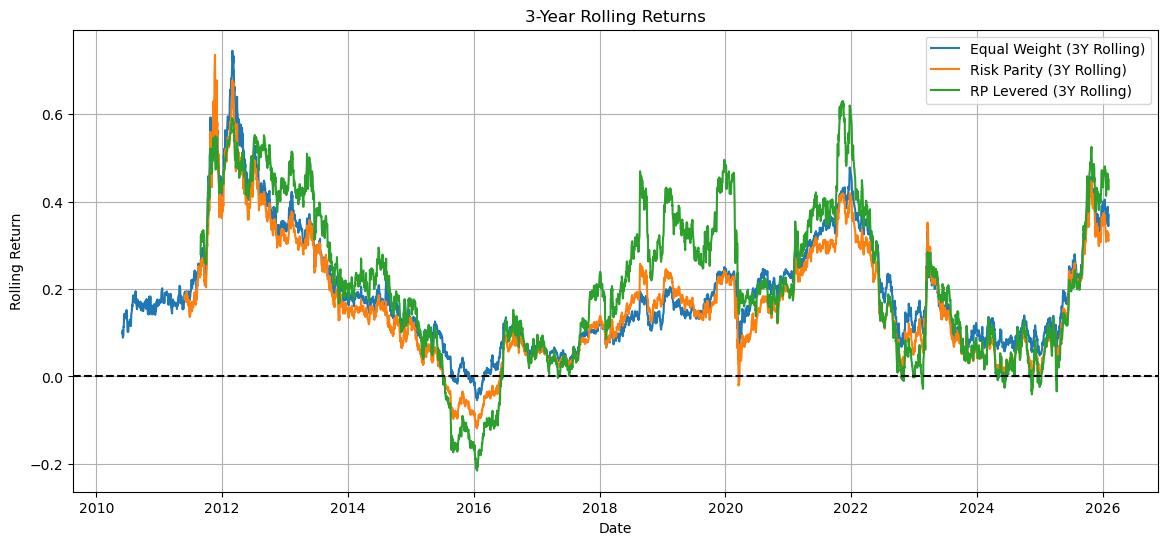

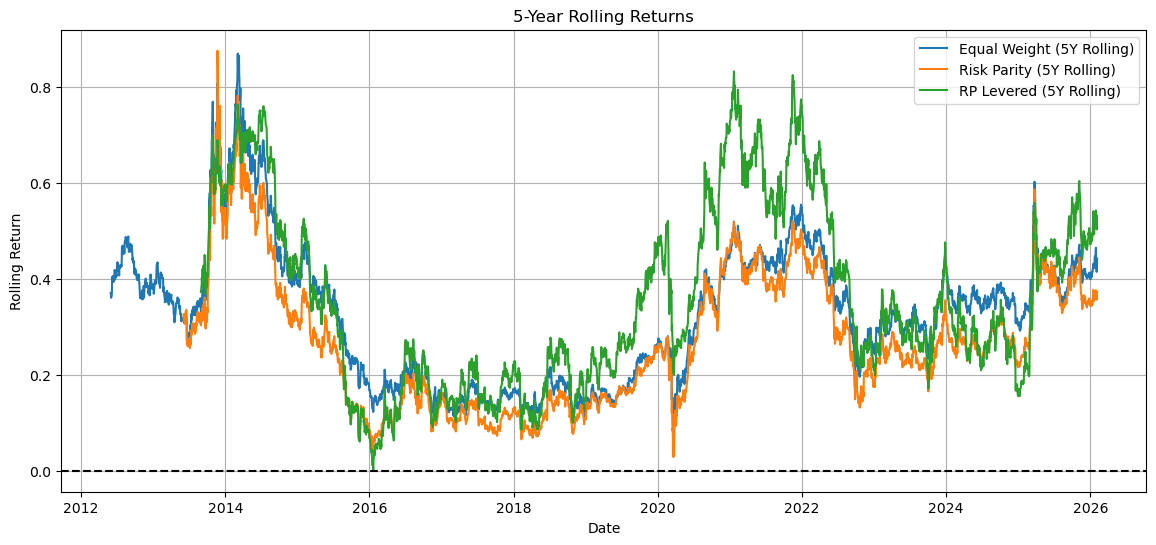

In [620]:
rolling_3y_equal = rolling_return(equal_equity, 252*3)
rolling_3y_rp = rolling_return(rp_equity, 252*3)
rolling_3y_levered = rolling_return(rp_levered_equity, 252*3)

rolling_5y_equal = rolling_return(equal_equity, 252*5)
rolling_5y_rp = rolling_return(rp_equity, 252*5)
rolling_5y_levered = rolling_return(rp_levered_equity, 252*5)


# ---- 3 YEAR PLOT ----
plt.figure(figsize=(14,6))
plt.plot(rolling_3y_equal, label="Equal Weight (3Y Rolling)")
plt.plot(rolling_3y_rp, label="Risk Parity (3Y Rolling)")
plt.plot(rolling_3y_levered, label="RP Levered (3Y Rolling)")
plt.axhline(0, color="black", linestyle="--")
plt.title("3-Year Rolling Returns")
plt.xlabel("Date")
plt.ylabel("Rolling Return")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_returns_3y.png", dpi=300, bbox_inches="tight")
plt.show()


# ---- 5 YEAR PLOT ----
plt.figure(figsize=(14,6))
plt.plot(rolling_5y_equal, label="Equal Weight (5Y Rolling)")
plt.plot(rolling_5y_rp, label="Risk Parity (5Y Rolling)")
plt.plot(rolling_5y_levered, label="RP Levered (5Y Rolling)")
plt.axhline(0, color="black", linestyle="--")
plt.title("5-Year Rolling Returns")
plt.xlabel("Date")
plt.ylabel("Rolling Return")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_returns_5y.png", dpi=300, bbox_inches="tight")
plt.show()


## ROLLING VOLATILITY (1 YEAR)


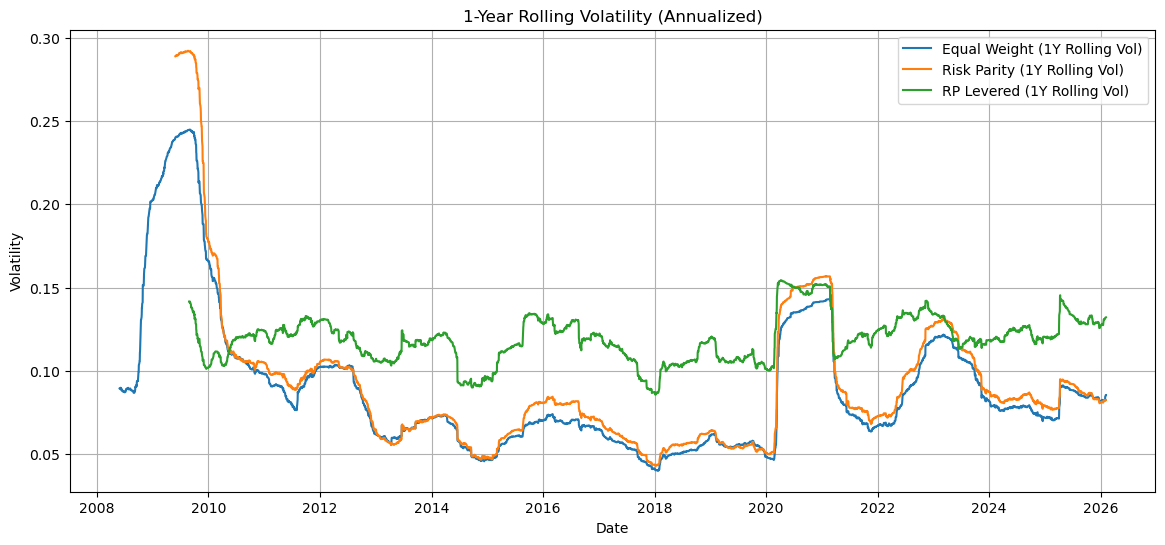

In [622]:
rolling_vol_equal = equal_returns.rolling(252).std() * np.sqrt(252)
rolling_vol_rp = rp_daily_returns.rolling(252).std() * np.sqrt(252)
rolling_vol_rp_levered = rp_levered_returns.rolling(252).std() * np.sqrt(252)

plt.figure(figsize=(14,6))
plt.plot(rolling_vol_equal, label="Equal Weight (1Y Rolling Vol)")
plt.plot(rolling_vol_rp, label="Risk Parity (1Y Rolling Vol)")
plt.plot(rolling_vol_rp_levered, label="RP Levered (1Y Rolling Vol)")
plt.title("1-Year Rolling Volatility (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_volatility_1y.png", dpi=300, bbox_inches="tight")
plt.show()


## ROLLING SHARPE RATIO (1 YEAR)


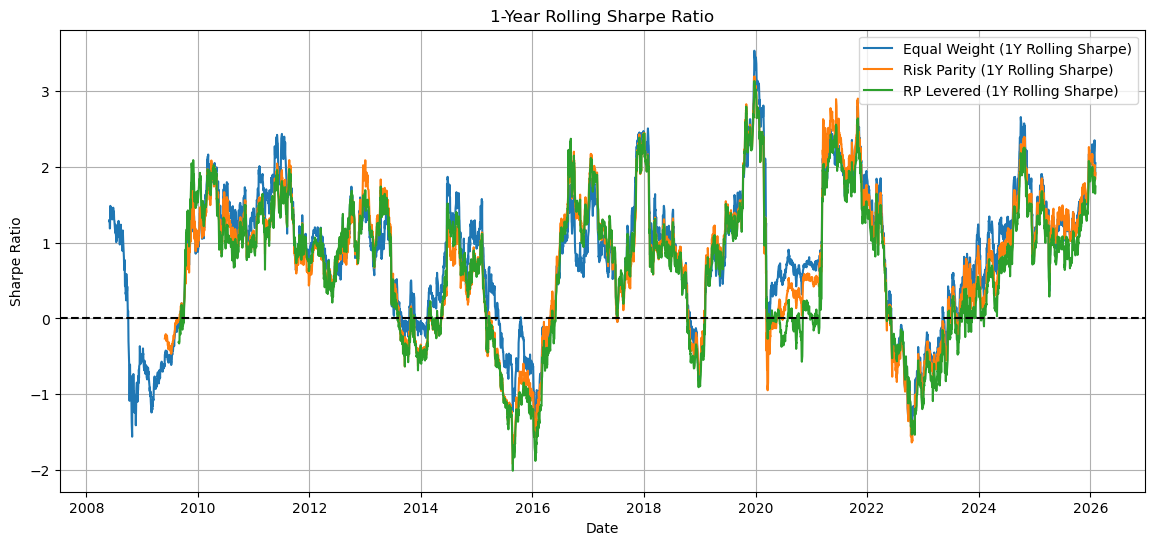

In [624]:
rolling_sharpe_equal = (equal_returns.rolling(252).mean() / equal_returns.rolling(252).std()) * np.sqrt(252)
rolling_sharpe_rp = (rp_daily_returns.rolling(252).mean() / rp_daily_returns.rolling(252).std()) * np.sqrt(252)
rolling_sharpe_rp_levered = (rp_levered_returns.rolling(252).mean() / rp_levered_returns.rolling(252).std()) * np.sqrt(252)

plt.figure(figsize=(14,6))
plt.plot(rolling_sharpe_equal, label="Equal Weight (1Y Rolling Sharpe)")
plt.plot(rolling_sharpe_rp, label="Risk Parity (1Y Rolling Sharpe)")
plt.plot(rolling_sharpe_rp_levered, label="RP Levered (1Y Rolling Sharpe)")

plt.axhline(0, color="black", linestyle="--")
plt.title("1-Year Rolling Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_sharpe_1y.png", dpi=300, bbox_inches="tight")
plt.show()


## 1-YEAR ROLLING MAX DRAWDOWN

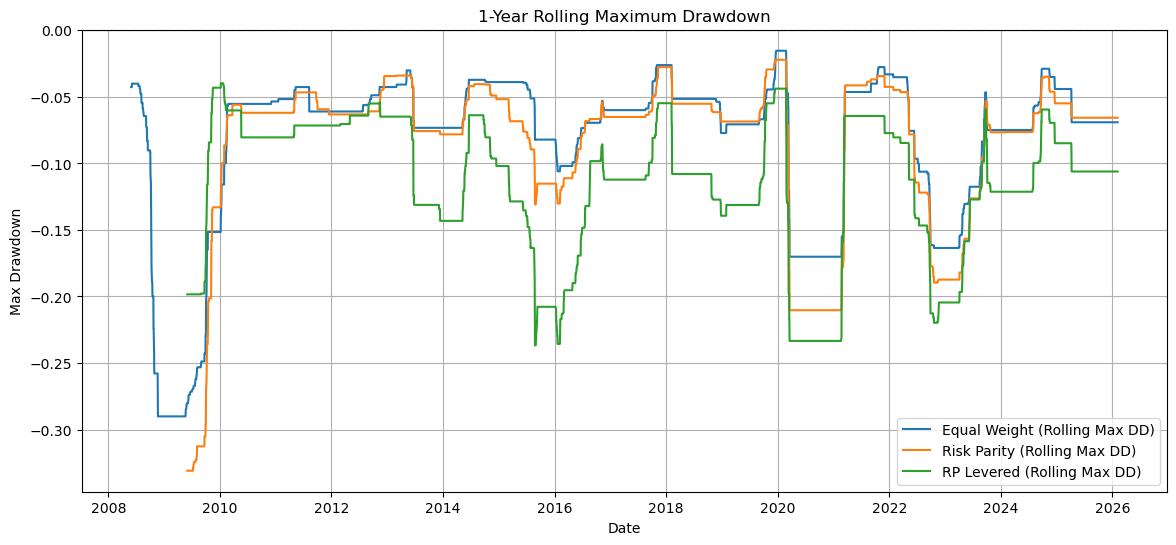

In [626]:
def rolling_max_drawdown(equity_curve, window=252):
    rolling_dd = []
    for i in range(len(equity_curve)):
        if i < window:
            rolling_dd.append(np.nan)
        else:
            window_curve = equity_curve.iloc[i-window:i]
            peak = window_curve.cummax()
            dd = (window_curve / peak) - 1
            rolling_dd.append(dd.min())
    return pd.Series(rolling_dd, index=equity_curve.index)

rolling_dd_equal = rolling_max_drawdown(equal_equity)
rolling_dd_rp = rolling_max_drawdown(rp_equity)
rolling_dd_rp_levered = rolling_max_drawdown(rp_levered_equity)

plt.figure(figsize=(14,6))
plt.plot(rolling_dd_equal, label="Equal Weight (Rolling Max DD)")
plt.plot(rolling_dd_rp, label="Risk Parity (Rolling Max DD)")
plt.plot(rolling_dd_rp_levered, label="RP Levered (Rolling Max DD)")

plt.axhline(0, color="black", linestyle="--")
plt.title("1-Year Rolling Maximum Drawdown")
plt.xlabel("Date")
plt.ylabel("Max Drawdown")
plt.grid(True)
plt.legend()
plt.savefig("outputs/rolling_max_drawdown_1y.png", dpi=300, bbox_inches="tight")
plt.show()


# Best Strategy Printouts

In [572]:
print("\n================= BEST STRATEGY SUMMARY =================\n")

# Best Sharpe
best_sharpe = metrics_df["Sharpe"].idxmax()
print("🏆 Best Strategy (Highest Sharpe Ratio):", best_sharpe)
print("Sharpe:", round(metrics_df.loc[best_sharpe, "Sharpe"], 4))

# Best CAGR
best_cagr = metrics_df["CAGR"].idxmax()
print("\n🚀 Best Strategy (Highest CAGR):", best_cagr)
print("CAGR:", round(metrics_df.loc[best_cagr, "CAGR"], 4))

# Lowest Max Drawdown (least negative is best)
best_drawdown = metrics_df["Max Drawdown"].idxmax()
print("\n🛡️ Safest Strategy (Lowest Max Drawdown):", best_drawdown)
print("Max Drawdown:", round(metrics_df.loc[best_drawdown, "Max Drawdown"], 4))

# Best Calmar
best_calmar = metrics_df["Calmar"].idxmax()
print("\n📈 Best Strategy (Highest Calmar Ratio):", best_calmar)
print("Calmar:", round(metrics_df.loc[best_calmar, "Calmar"], 4))

print("\n=========================================================\n")

print("📌 Full Performance Metrics Sorted by Sharpe Ratio:\n")

metrics_df.style.format({
    "CAGR": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe": "{:.2f}",
    "Sortino": "{:.2f}",
    "Max Drawdown": "{:.2%}",
    "Calmar": "{:.2f}"
})



================= BEST STRATEGY SUMMARY =================

🏆 Best Strategy (Highest Sharpe Ratio): Equal Weight
Sharpe: 0.6611

🚀 Best Strategy (Highest CAGR): RP Levered
CAGR: 0.0752

🛡️ Safest Strategy (Lowest Max Drawdown): RP Levered
Max Drawdown: -0.2112

📈 Best Strategy (Highest Calmar Ratio): RP Levered
Calmar: 0.3558


📌 Full Performance Metrics Sorted by Sharpe Ratio:



,CAGR,Volatility,Sharpe,Sortino,Max Drawdown,Calmar
Portfolio,,,,,,
Equal Weight,6.18%,9.81%,0.66,0.84,-29.01%,0.21
Risk Parity,5.49%,10.12%,0.58,0.73,-29.66%,0.18
Risk Parity (With Cost),4.66%,10.13%,0.50,0.63,-29.97%,0.16
RP Levered,7.52%,12.22%,0.66,0.88,-21.12%,0.36
RP Levered (With Cost),6.67%,12.23%,0.59,0.80,-21.44%,0.31


# Future Improvements
- Use a shrinkage covariance estimator (Ledoit-Wolf)
- Add risk-free rate from T-bills instead of assuming 0
- Compare against 60/40 SPY-TLT benchmark
- Add out-of-sample testing split (train/test)


# Conclusion

## Key Findings
- Equal Weight portfolio achieved the best Sharpe ratio, showing strong risk-adjusted performance.
- Risk Parity provided more diversified allocations but produced slightly lower returns.
- Adding transaction costs significantly reduced Risk Parity performance due to higher turnover.
- Leveraged Risk Parity achieved the highest CAGR but increased volatility and risk.

## Recommendation
- For best risk-adjusted return → Equal Weight
- For highest growth potential → Leveraged Risk Parity
- For realistic implementation with costs → Equal Weight remains the strongest choice
